# IMPORTS

In [ ]:
# Clone the Git repository and navigate to the project directory
!git clone https://github.com/DanteMillerDS/MPA_Predictor.git
%cd MPA_Predictor

# Install required packages
!pip install xgboost
!pip install pytorch-tabnet
!pip install torch

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import uuid
from IPython.display import display
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import torch
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from pytorch_tabnet.tab_model import TabNetRegressor
import keras
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Set random seeds for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

Cloning into 'MPA_Predictor'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 66 (delta 16), reused 37 (delta 7), pack-reused 0
Receiving objects: 100% (66/66), 8.67 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/MPA_Predictor
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00


# PREPROCESSING

In [ ]:
# Read files
file_paths = dict()
file_paths[0] = ["data/patch_s11_data.txt"]

# Process files
def process_file(file_path):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}"])
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            df[key.replace(" ", "")] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [ ]:
# Print columns
print(training_dataframe.columns)

Index(['Frequency', 'data/patch_s11_data.txt', 'ID', 'xs', 'L', 'cl', 'er1',
       'er11', 'er2', 'er22', 'h', 'r0', 'rin', 'rprobe', 't', 'w', 'wx',
       'wy'],
      dtype='object')


In [ ]:
# Grab specific columns
needed_columns = ["Frequency","data/patch_s11_data.txt","h","t","er11","er1","w","L"]
training_dataframe = training_dataframe[needed_columns]

In [ ]:
# Define variable names
training_dataframe.columns = ["Frequency","Behavior","Substrate_Thickness","Patch_Thickness","Permittivity_Imaginary","Permittivity_Real","Width","Length"]

In [ ]:
# Print variable names
training_dataframe.columns

Index(['Frequency', 'Behavior', 'Substrate_Thickness', 'Patch_Thickness',
       'Permittivity_Imaginary', 'Permittivity_Real', 'Width', 'Length'],
      dtype='object')

In [ ]:
# Drop na and applying numeric
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)

<ipython-input-7-454ede49bebf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_dataframe.dropna(inplace=True)


In [ ]:
# Describe dataframe
training_dataframe.describe()

,Behavior,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
count,100100.000000,1.001000e+05,1.001000e+05,1.001000e+05,1.001000e+05,100100.000000,100100.000000
mean,-5.635724,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,23.239859,30.986479
std,4.272031,2.220457e-16,2.775571e-17,1.734732e-18,4.440914e-16,2.641224,3.521632
min,-39.612127,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,18.895192,25.193589
25%,-7.488767,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,21.050639,28.067519
50%,-4.347330,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,22.904012,30.538683
75%,-2.482638,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,25.086270,33.448360
max,-1.123604,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,28.116379,37.488505


In [ ]:
# Print dataframe head
training_dataframe.head(5)

,Frequency,Behavior,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
0,8.0000000000000,-14.610955,1.6,0.2,0.01,2.55,24.933799,33.245066
1,8.0039997100830,-14.570352,1.6,0.2,0.01,2.55,24.933799,33.245066
2,8.0080003738403,-14.520970,1.6,0.2,0.01,2.55,24.933799,33.245066
3,8.0120000839233,-14.462995,1.6,0.2,0.01,2.55,24.933799,33.245066
4,8.0159997940063,-14.396675,1.6,0.2,0.01,2.55,24.933799,33.245066


In [ ]:
# Find lowest impudance value in each set
lowest_impedance_rows = pd.DataFrame(columns=training_dataframe.columns)
for i in range(0,len(training_dataframe),1001):
  subset = training_dataframe[i:i+1001]
  min_impedance_row = subset[subset['Behavior'] == subset['Behavior'].min()]
  lowest_impedance_rows = pd.concat([lowest_impedance_rows, min_impedance_row])

In [ ]:
# Show new dataframe
lowest_impedance_rows

,Frequency,Behavior,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
0,8.0000000000000,-14.610955,1.6,0.2,0.01,2.55,24.933799,33.245066
1103,8.4079999923706,-19.107793,1.6,0.2,0.01,2.55,23.611828,31.482437
2436,9.7360000610352,-27.446728,1.6,0.2,0.01,2.55,27.871636,37.162182
3710,10.828000068665,-17.361629,1.6,0.2,0.01,2.55,24.834295,33.112394
4611,10.428000450134,-13.896830,1.6,0.2,0.01,2.55,26.253099,35.004132
...,...,...,...,...,...,...,...,...
95777,10.727999687195,-14.778299,1.6,0.2,0.01,2.55,25.311449,33.748598
96812,10.864000320435,-17.091459,1.6,0.2,0.01,2.55,24.736226,32.981634
97340,8.9720001220703,-35.559354,1.6,0.2,0.01,2.55,19.065036,25.420048
98933,11.340000152588,-34.824999,1.6,0.2,0.01,2.55,19.395057,25.860076


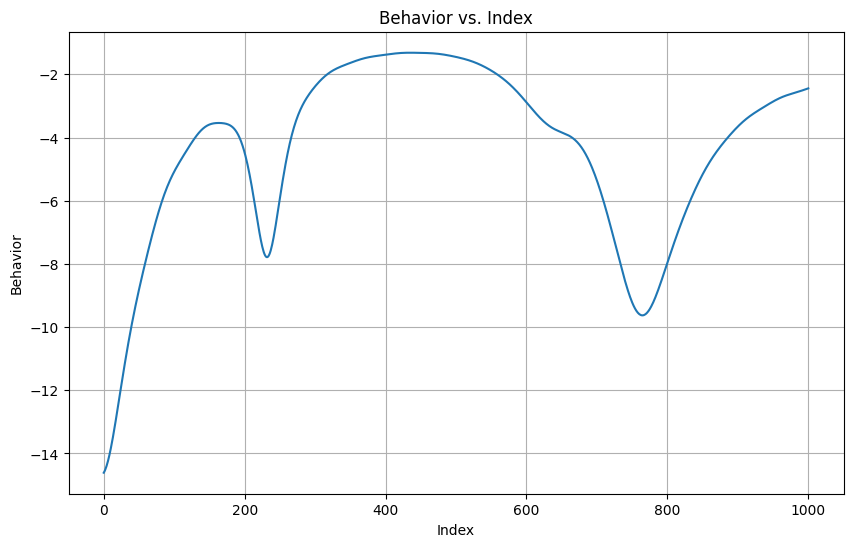

In [ ]:
# Behavior Set 1
behavior_data = training_dataframe.iloc[0:1001]["Behavior"]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(behavior_data, linestyle='-')  # Customize the plot style if desired
plt.title("Behavior vs. Index")
plt.xlabel("Index")
plt.ylabel("Behavior")
plt.grid(True)
plt.show()

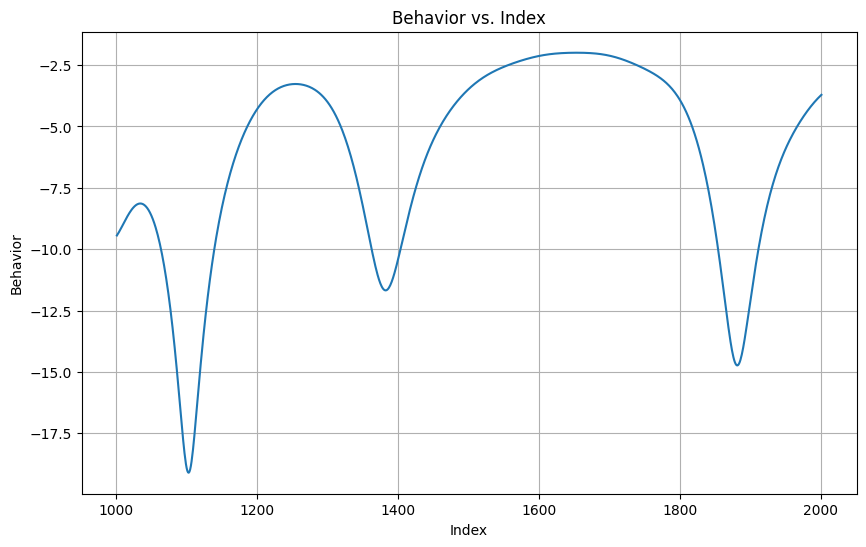

In [ ]:
# Behavior Set 2
behavior_data = training_dataframe.iloc[1001:2002]["Behavior"]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(behavior_data, linestyle='-')  # Customize the plot style if desired
plt.title("Behavior vs. Index")
plt.xlabel("Index")
plt.ylabel("Behavior")
plt.grid(True)
plt.show()

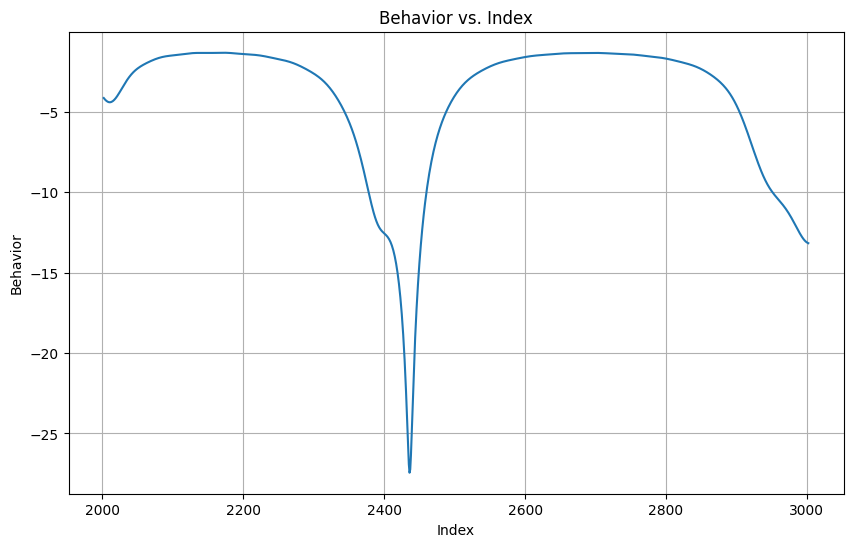

In [ ]:
# Behavior Set 3
behavior_data = training_dataframe.iloc[2002:3003]["Behavior"]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(behavior_data, linestyle='-')  # Customize the plot style if desired
plt.title("Behavior vs. Index")
plt.xlabel("Index")
plt.ylabel("Behavior")
plt.grid(True)
plt.show()

In [ ]:
# Set training dataframe equaled to lowest imepedance dataframe
training_dataframe = lowest_impedance_rows

# DATA VISUALIZATION

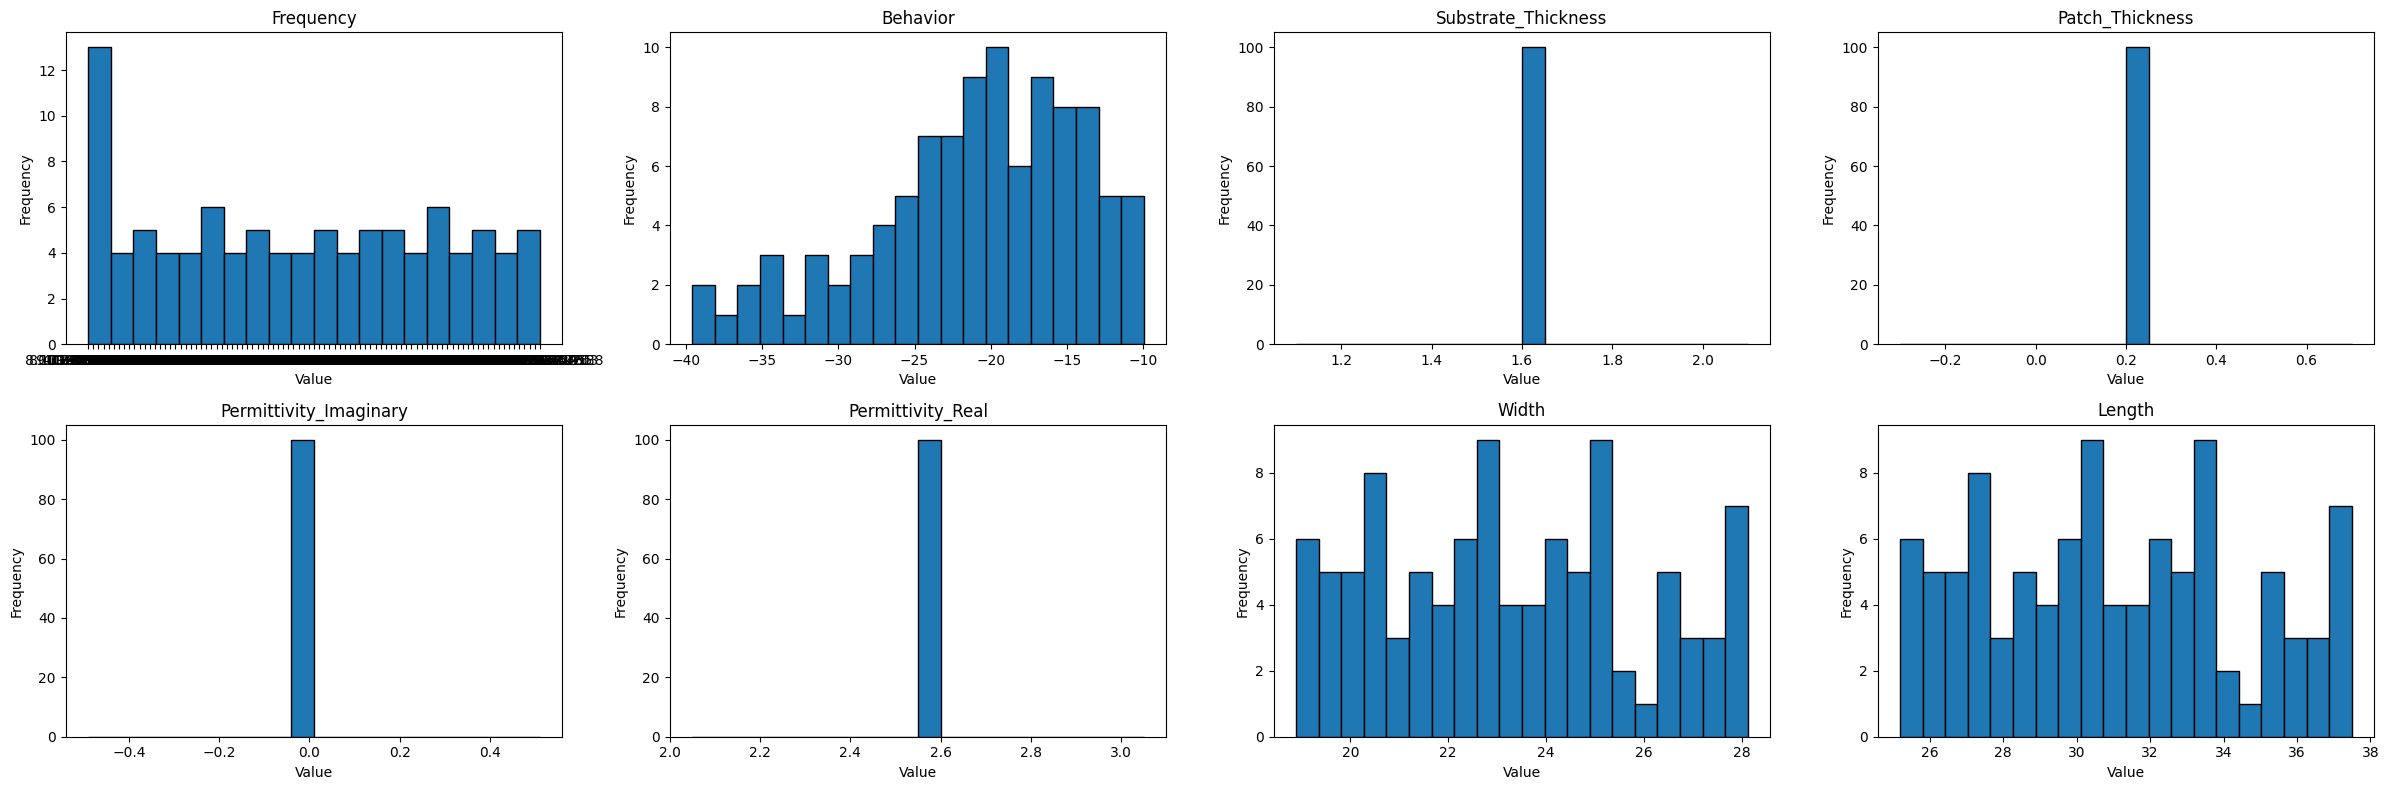

In [ ]:
# Plot columns
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Grabbing column means
columns = ["Behavior","Width","Length"]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()

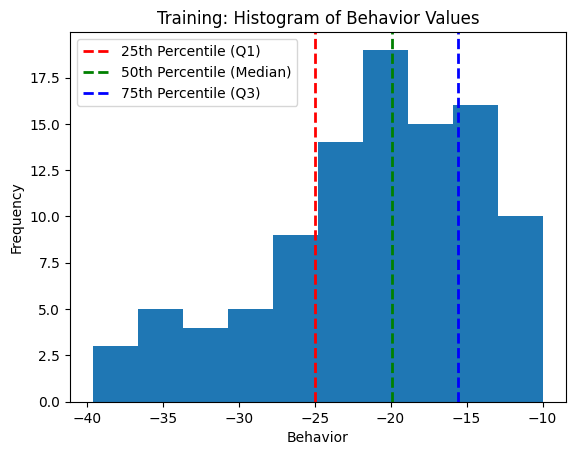

In [ ]:
# Showing mean for the input impedance
q25 = np.percentile(training_dataframe["Behavior"], 25)
q50 = np.percentile(training_dataframe["Behavior"], 50)
q75 = np.percentile(training_dataframe["Behavior"], 75)
plt.hist(training_dataframe["Behavior"])
plt.xlabel("Behavior")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Behavior Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

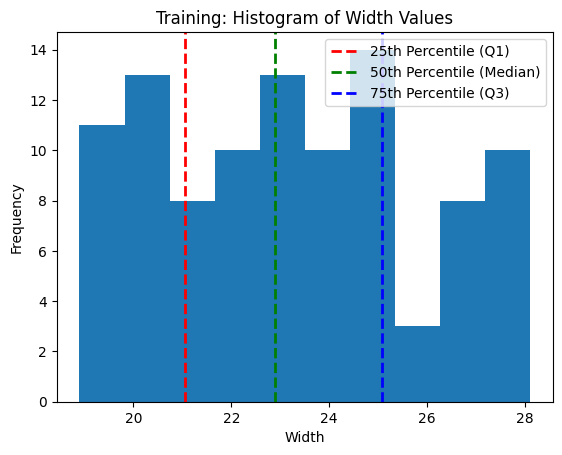

In [ ]:
# Showing mean for the width
q25 = np.percentile(training_dataframe["Width"], 25)
q50 = np.percentile(training_dataframe["Width"], 50)
q75 = np.percentile(training_dataframe["Width"], 75)
plt.hist(training_dataframe["Width"])
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Width Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

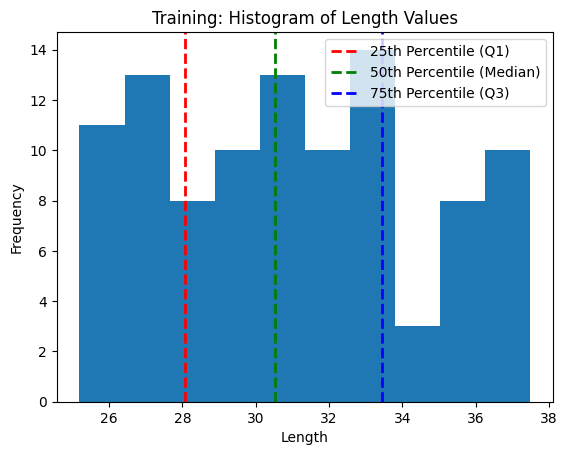

In [ ]:
# Showing mean for the length
q25 = np.percentile(training_dataframe["Length"], 25)
q50 = np.percentile(training_dataframe["Length"], 50)
q75 = np.percentile(training_dataframe["Length"], 75)
plt.hist(training_dataframe["Length"])
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Length Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

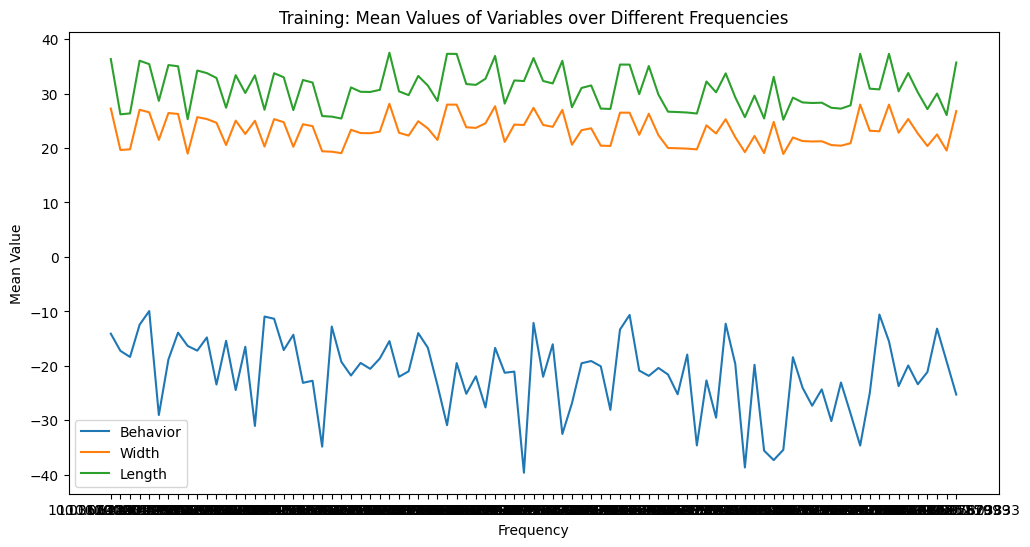

In [ ]:
# Plot mean over frequencies
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

# DATA MANIPULATION

In [ ]:
# Divide by 100
training_dataframe["Substrate_Thickness"] /= 100
training_dataframe["Permittivity_Real"] /= 100

In [ ]:
# Power transform
bc = PowerTransformer()
bc.fit(training_dataframe[["Frequency"]])
training_dataframe[training_dataframe[["Frequency"]].columns] = bc.transform(training_dataframe[["Frequency"]])
bc = PowerTransformer()
bc.fit(training_dataframe[["Behavior"]])
training_dataframe[training_dataframe[["Behavior"]].columns] = bc.transform(training_dataframe[["Behavior"]])

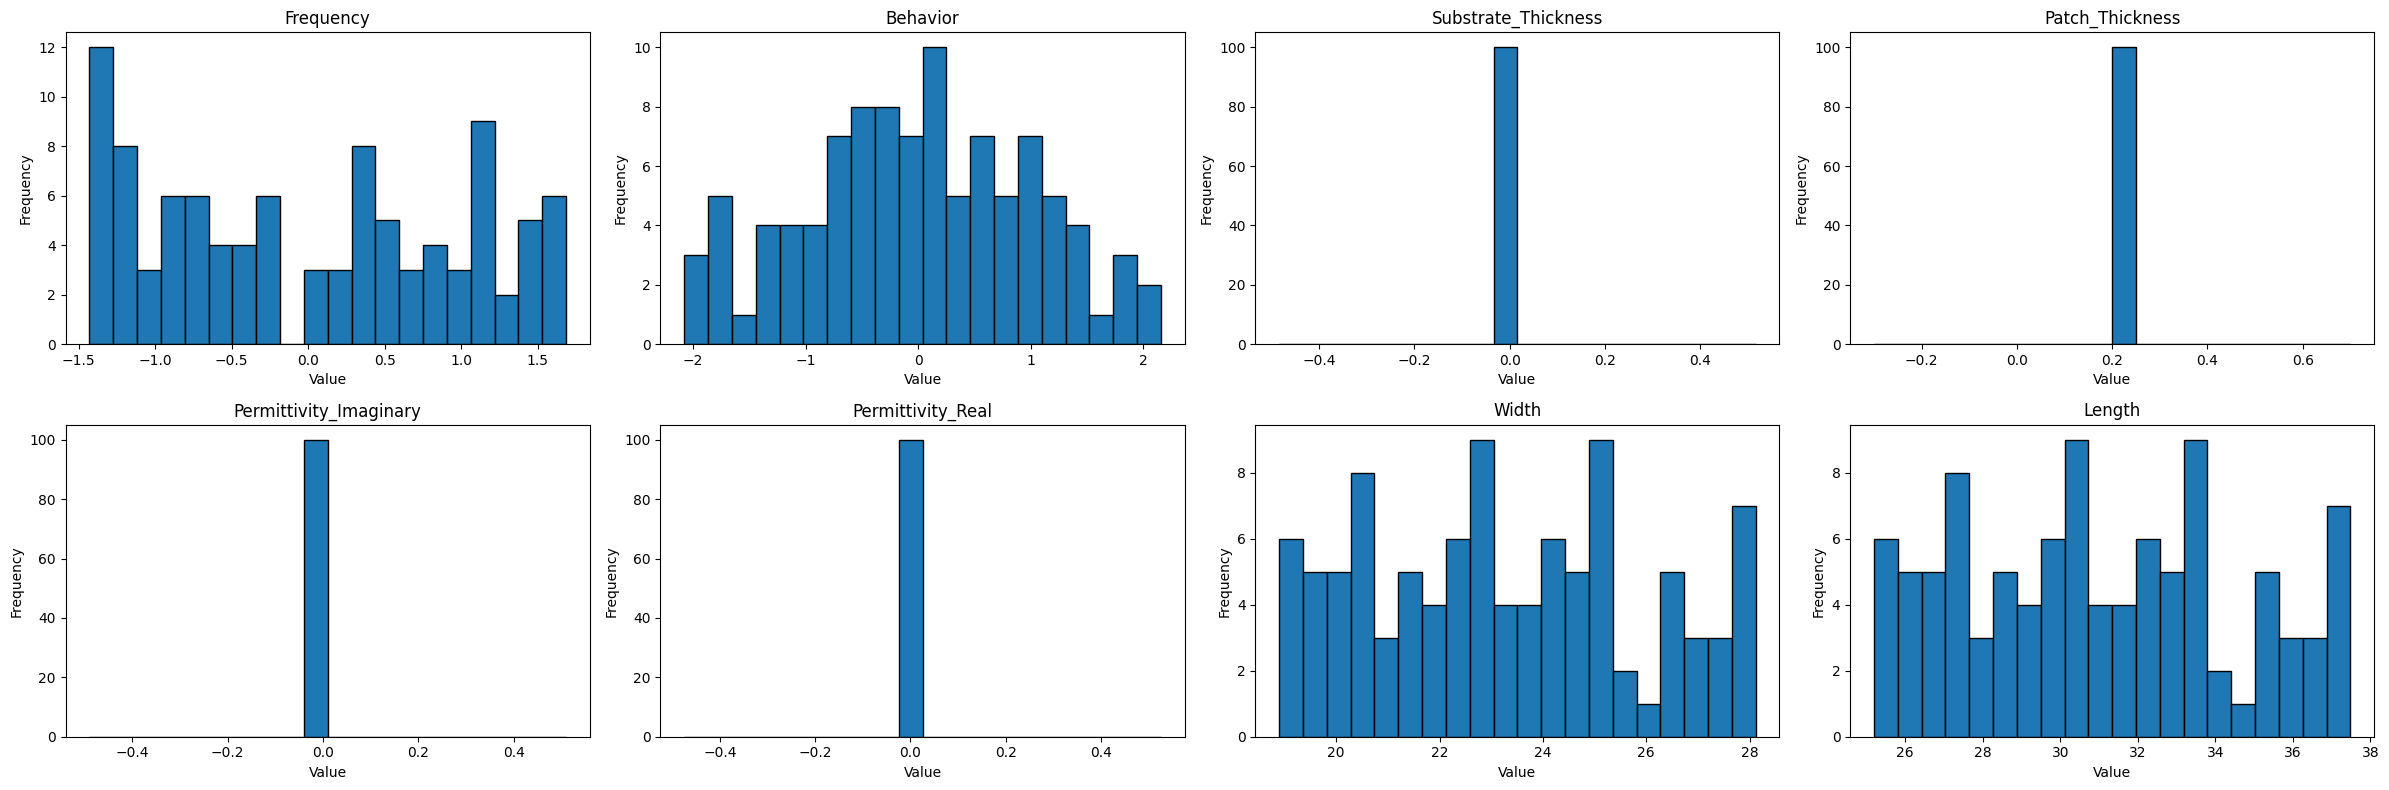

In [ ]:
# Plot
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# MODELS

In [ ]:
# Hyperparameters
LR = 0.001
L2 = 0.0001
WD = 0.00001

In [ ]:
# Column names
columns = []
for column in training_dataframe.columns:
    if column not in ["Behavior","Substrate_Thickness","Patch_Thickness","Permittivity_Imaginary","Permittivity_Real"]:
        columns.append(column)
columns

['Frequency', 'Width', 'Length']

In [ ]:
# K fold
X_train = training_dataframe[columns].values
y_train = training_dataframe[["Behavior"]].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
train_indices, test_indices = train_test_split(selected_indices, test_size=0.1, random_state=100)
kf = KFold(n_splits=5, shuffle=True, random_state=100)
X_train_indices = dict()
X_val_indices = dict()
X_test_indices = dict()
for index, (train_indices, val_indices) in enumerate(kf.split(train_indices)):
    X_train_indices[index] = train_indices
    X_val_indices[index] = val_indices
    X_test_indices[index] = test_indices

In [ ]:
# Showing number of observations
num_obs_train = len(X_selected[train_indices])
num_obs_val = len(X_selected[val_indices])
num_obs_test = len(X_selected[test_indices])
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
            'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                      72
1  Validation                      18
2        Test                      10
3       Total                     100


In [ ]:
# Train models
def train_models(X_train,y_train,X_val,y_val):
    # Linear Regression Model
    lin_reg_model = LinearRegression()
    lin_reg_model.fit(X_train, y_train)

    # Lasso Regression Model
    lasso_reg_model = Lasso(alpha=0.1)
    lasso_reg_model.fit(X_train, y_train)

    # Ridge Regression Model
    ridge_reg_model = Ridge(alpha=0.1)
    ridge_reg_model.fit(X_train, y_train)

    # Support Vector Machine (SVM) Model
    svm_model = SVR(kernel='rbf')
    svm_model.fit(X_train, y_train)

    # Decision Tree Regression Model
    dt_model = DecisionTreeRegressor()
    dt_model.fit(X_train, y_train)

    # Neural Network Model
    def rmse_loss(y_true, y_pred):
      squared_error = tf.square(y_true - y_pred)
      mean_squared_error = tf.reduce_mean(squared_error)
      root_mean_squared_error = tf.sqrt(mean_squared_error)
      return root_mean_squared_error

    nn_model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])


    nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
                  loss=[rmse_loss],
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
    nn_model.summary()
    history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,shuffle=True)

    # XGBoost Model
    xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric=mean_absolute_error,verbosity=3,max_depth=6)
    xgb_model.fit(X_train, y_train)

    # TabNet Model
    X_train_tensor = torch.tensor(X_train , dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    tabnet_model = TabNetRegressor(device_name = "cuda")
    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['mae'],
        max_epochs=75,
        batch_size = 5
    )

    return lin_reg_model, lasso_reg_model, ridge_reg_model, svm_model, dt_model, nn_model, xgb_model, tabnet_model

In [ ]:
# Call train models function on each k fold
model_dictionary = dict()
for i in range(index+1):
  X_train_index = X_train_indices[i]
  X_val_index = X_val_indices[i]
  X_test_index = X_test_indices[i]
  X_train = X_selected[X_train_index]
  y_train = y_selected[X_train_index]
  X_val = X_selected[X_val_index]
  y_val = y_selected[X_val_index]
  X_test = X_selected[X_test_index]
  y_test = y_selected[X_test_index]
  X_train = X_train.astype(float)
  y_train = y_train.astype(float)
  X_val = X_val.astype(float)
  y_val = y_val.astype(float)
  X_test = X_test.astype(float)
  y_test = y_test.astype(float)

  lin_reg_model, lasso_reg_model, ridge_reg_model, svm_model, dt_model, nn_model, xgb_model, tabnet_model = train_models(X_train,y_train,X_val,y_val)
  model_dictionary[i] = [lin_reg_model, lasso_reg_model, ridge_reg_model, svm_model, dt_model, nn_model, xgb_model, tabnet_model]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11393 (44.50 KB)
Trainable params: 11393 (44.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3/3 [==============================] - 5s 680ms/step - loss: 9.1843 - mean_absolute_error: 9.0016 - mean_squared_error: 84.7492 - val_loss: 7.3634 - val_mean_absolute_error: 7.2188 - val_mean_squared_error: 53.5295
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 7.2653 - mean_absolute_error: 7.0518 - mean_squared_error: 52.5214 - val_loss: 5.4705 - val_mean_absolute_error: 5.3198 - val_mean_squared_error: 29.4145
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 5.3485 - mean_absolute_error: 5.1202 - mean_squared_error: 28.5492 - val_loss: 3.6108 - val_mean_absolute_error: 3.4338 - val_mean_squared_error: 12.7013
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 3.4987 - mean_absolute_error: 3.2096 - mean_squared_error: 12.1604 - val_loss: 1.8573 - val_mean_absolute_error: 1.6201 - val_mean_squared_error: 3.2775
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 1.8116 - mean_absolute_error: 1.4935

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[08:31:54] ======== Monitor (0):  ========
[08:31:54] InitCompressedData: 6.3e-05s, 1 calls @ 63us

[08:31:54] ======== Monitor (0): Learner ========
[08:31:54] Configure: 0.047807s, 1 calls @ 47807us

[08:31:54] EvalOneIter: 0.000865s, 250 calls @ 865us

[08:31:54] GetGradient: 0.009962s, 250 calls @ 9962us

[08:31:54] PredictRaw: 0.000349s, 250 calls @ 349us

[08:31:54] UpdateOneIter: 0.314943s, 250 calls @ 314943us

[08:31:54] ======== Monitor (0): GBTree ========
[08:31:54] BoostNewTrees: 0.212157s, 250 calls @ 212157us

[08:31:54] CommitModel: 9e-05s, 250 calls @ 90us

[08:31:54] ======== Device 0 Memory Allocations:  ========
[08:31:54] Peak memory usage: 32MiB
[08:31:54] Number of allocations: 7382
[08:31:54] ======== Monitor (0): updater_gpu_hist ========
[08:31:54] InitData: 0.000763s, 250 calls @ 763us

[08:31:54] InitDataOnce: 0.000711s, 1 calls @ 711us

[08:31:54] Update: 0.204073s, 250 calls @ 204073us

[08:31:54] UpdatePredictionCache: 0.007063s, 250 calls @ 7063us

[08:3

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3/3 [==============================] - 3s 287ms/step - loss: 35.2735 - mean_absolute_error: 34.9929 - mean_squared_error: 1241.5436 - val_loss: 32.4740 - val_mean_absolute_error: 32.2861 - val_mean_squared_error: 1051.4962
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 31.7979 - mean_absolute_error: 31.5419 - mean_squared_error: 1009.3665 - val_loss: 28.9945 - val_mean_absolute_error: 28.8238 - val_mean_squared_error: 837.9475
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 28.3820 - mean_absolute_error: 28.1377 - mean_squared_error: 803.3639 - val_loss: 25.5601 - val_mean_absolute_error: 25.4065 - val_mean_squared_error: 650.9149
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 24.9856 - mean_absolute_error: 24.7644 - mean_squared_error: 622.8212 - val_loss: 22.1413 - val_mean_absolute_error: 22.0047 - val_mean_squared_error: 488.1586
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 21.6043 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[08:33:04] ======== Monitor (0): Learner ========
[08:33:04] Configure: 0.001246s, 1 calls @ 1246us

[08:33:04] EvalOneIter: 0.000856s, 250 calls @ 856us

[08:33:04] GetGradient: 0.010133s, 250 calls @ 10133us

[08:33:04] PredictRaw: 0.000222s, 250 calls @ 222us

[08:33:04] UpdateOneIter: 0.159487s, 250 calls @ 159487us

[08:33:04] ======== Monitor (0): GBTree ========
[08:33:04] BoostNewTrees: 0.145055s, 250 calls @ 145055us

[08:33:04] CommitModel: 9.1e-05s, 250 calls @ 91us

[08:33:04] ======== Device 0 Memory Allocations:  ========
[08:33:04] Peak memory usage: 32MiB
[08:33:04] Number of allocations: 14518
[08:33:04] ======== Monitor (0): updater_gpu_hist ========
[08:33:04] InitData: 0.000494s, 250 calls @ 494us

[08:33:04] InitDataOnce: 0.000431s, 1 calls @ 431us

[08:33:04] Update: 0.136971s, 250 calls @ 136971us

[08:33:04] UpdatePredictionCache: 0.007025s, 250 calls @ 7025us

[08:33:04] ======== Monitor (0): gradient_based_sampler ========
[08:33:04] Sample: 0.000965s, 250 cal

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               512       
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 11393 (44.50 KB)
Trainable params: 11393 (44.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [=======================

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[08:34:10] ======== Monitor (0): Learner ========
[08:34:10] Configure: 0.001395s, 1 calls @ 1395us

[08:34:10] EvalOneIter: 0.00088s, 250 calls @ 880us

[08:34:10] GetGradient: 0.009894s, 250 calls @ 9894us

[08:34:10] PredictRaw: 0.000217s, 250 calls @ 217us

[08:34:10] UpdateOneIter: 0.156781s, 250 calls @ 156781us

[08:34:10] ======== Monitor (0): GBTree ========
[08:34:10] BoostNewTrees: 0.142512s, 250 calls @ 142512us

[08:34:10] CommitModel: 8.6e-05s, 250 calls @ 86us

[08:34:10] ======== Device 0 Memory Allocations:  ========
[08:34:10] Peak memory usage: 32MiB
[08:34:10] Number of allocations: 21490
[08:34:10] ======== Monitor (0): updater_gpu_hist ========
[08:34:10] InitData: 0.000465s, 250 calls @ 465us

[08:34:10] InitDataOnce: 0.000418s, 1 calls @ 418us

[08:34:10] Update: 0.134799s, 250 calls @ 134799us

[08:34:10] UpdatePredictionCache: 0.006692s, 250 calls @ 6692us

[08:34:10] ======== Monitor (0): gradient_based_sampler ========
[08:34:10] Sample: 0.000973s, 250 calls

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3/3 [==============================] - 3s 256ms/step - loss: 104.7666 - mean_absolute_error: 103.9774 - mean_squared_error: 10971.2500 - val_loss: 102.9496 - val_mean_absolute_error: 102.1883 - val_mean_squared_error: 10588.8730
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 100.5344 - mean_absolute_error: 99.7854 - mean_squared_error: 10099.5898 - val_loss: 98.7855 - val_mean_absolute_error: 98.0550 - val_mean_squared_error: 9749.2373
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 96.4332 - mean_absolute_error: 95.7438 - mean_squared_error: 9299.8564 - val_loss: 94.7944 - val_mean_absolute_error: 94.0990 - val_mean_squared_error: 8977.0264
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 92.6038 - mean_absolute_error: 91.8884 - mean_squared_error: 8567.4844 - val_loss: 90.9409 - val_mean_absolute_error: 90.2751 - val_mean_squared_error: 8261.6768
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 1.07948 | val_0_mae: 1.71659 |  0:00:00s
epoch 2  | loss: 1.12436 | val_0_mae: 7.15016 |  0:00:01s
epoch 3  | loss: 1.15032 | val_0_mae: 1.16997 |  0:00:01s
epoch 4  | loss: 0.95618 | val_0_mae: 4.34763 |  0:00:02s
epoch 5  | loss: 1.14046 | val_0_mae: 2.77745 |  0:00:02s
epoch 6  | loss: 1.06646 | val_0_mae: 1.72483 |  0:00:02s
epoch 7  | loss: 0.95952 | val_0_mae: 1.29082 |  0:00:03s
epoch 8  | loss: 1.01256 | val_0_mae: 1.1022  |  0:00:03s
epoch 9  | loss: 0.79651 | val_0_mae: 0.99344 |  0:00:04s
epoch 10 | loss: 0.9996  | val_0_mae: 0.92164 |  0:00:04s
epoch 11 | loss: 0.96909 | val_0_mae: 1.27476 |  0:00:04s
epoch 12 | loss: 0.98969 | val_0_mae: 1.11062 |  0:00:05s
epoch 13 | loss: 0.99533 | val_0_mae: 0.86022 |  0:00:05s
epoch 14 | loss: 0.98591 | val_0_mae: 0.84591 |  0:00:06s
epoch 15 | loss: 1.01088 | val_0_mae: 0.85335 |  0:00:06s
epoch 16 | loss: 0.98772 | val_0_mae: 0.87399 |  0:00:07s
epoch 17 | loss: 1.04061 | val_0_mae: 0.85421 |  0:00:07s
epoch 18 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3/3 [==============================] - 3s 259ms/step - loss: 52.3140 - mean_absolute_error: 51.9100 - mean_squared_error: 2732.0491 - val_loss: 48.7786 - val_mean_absolute_error: 48.4006 - val_mean_squared_error: 2374.4639
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 49.4671 - mean_absolute_error: 49.0851 - mean_squared_error: 2442.1602 - val_loss: 46.0130 - val_mean_absolute_error: 45.6564 - val_mean_squared_error: 2112.5938
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 46.6649 - mean_absolute_error: 46.3051 - mean_squared_error: 2173.7517 - val_loss: 43.3311 - val_mean_absolute_error: 42.9952 - val_mean_squared_error: 1873.2592
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 43.9365 - mean_absolute_error: 43.5975 - mean_squared_error: 1928.0807 - val_loss: 40.7246 - val_mean_absolute_error: 40.4092 - val_mean_squared_error: 1654.4355
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 41.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 1.17213 | val_0_mae: 1.99867 |  0:00:00s
epoch 2  | loss: 1.14044 | val_0_mae: 17.8817 |  0:00:01s
epoch 3  | loss: 1.01388 | val_0_mae: 9.46546 |  0:00:01s
epoch 4  | loss: 1.13103 | val_0_mae: 2.55398 |  0:00:02s
epoch 5  | loss: 0.98327 | val_0_mae: 2.10425 |  0:00:02s
epoch 6  | loss: 1.30236 | val_0_mae: 0.95606 |  0:00:02s
epoch 7  | loss: 1.10556 | val_0_mae: 0.78779 |  0:00:03s
epoch 8  | loss: 1.14785 | val_0_mae: 0.78352 |  0:00:03s
epoch 9  | loss: 1.01955 | val_0_mae: 0.77499 |  0:00:04s
epoch 10 | loss: 1.09779 | val_0_mae: 0.75425 |  0:00:04s
epoch 11 | loss: 1.04623 | val_0_mae: 0.72777 |  0:00:05s
epoch 12 | loss: 1.17375 | val_0_mae: 0.74107 |  0:00:05s
epoch 13 | loss: 1.14253 | val_0_mae: 0.70542 |  0:00:06s
epoch 14 | loss: 1.13287 | val_0_mae: 0.73752 |  0:00:06s
epoch 15 | loss: 1.05958 | val_0_mae: 0.73225 |  0:00:07s
epoch 16 | loss: 1.11505 | val_0_mae: 0.7245  |  0:00:07s
epoch 17 | loss: 1.02971 | val_0_mae: 0.66466 |  0:00:07s
epoch 18 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# EVALUATION

In [ ]:
# Evaluation tables
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
names = ["Behavior"]
model_names = ["Linear Regression", "Lasso Regression", "Ridge Regression", "Support Vector Machine (SVM)", "Decision Tree Regression", "Neural Network", "XGBoost", "TabNet"]

num_models = len(model_dictionary)
num_targets = 1
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    models = model_dictionary[i]
    y_pred_models[i] = [bc.inverse_transform(model.predict(X_test).reshape(-1, 1)) for model in models]
inverse_y = bc.inverse_transform(y_test)
for i in range(num_targets):
    y_test_targets[i] = inverse_y

for t in range(num_targets):
    metrics_data = []
    y_test_target = y_test_targets[t]
    target_data = {
        "Target": names[t]
    }
    for model_type in range(len(y_pred_models[0])):
        mean = np.zeros_like(y_pred_models[0][model_type][:, t])
        squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
        for k_fold in range(len(y_pred_models)):
            y_pred_fold = y_pred_models[k_fold][model_type][:, t]
            mean += y_pred_fold
            squared_diff_sum += (y_pred_fold - mean) ** 2
        mean = mean / len(y_pred_models)
        std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
        mse = mean_squared_error(y_test_target, mean)
        mae = mean_absolute_error(y_test_target, mean)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test_target, mean)
        target_data[f"Mean ({model_names[model_type]})"] = mean
        target_data[f"SD ({model_names[model_type]})"] = std_deviation
        target_data[f"MSE ({model_names[model_type]})"] = mse
        target_data[f"MAE ({model_names[model_type]})"] = mae
        target_data[f"RMSE ({model_names[model_type]})"] = rmse
        target_data[f"R² ({model_names[model_type]})"] = r_squared

    metrics_data.append(target_data)
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

,Target,Mean (Linear Regression),SD (Linear Regression),MSE (Linear Regression),MAE (Linear Regression),RMSE (Linear Regression),R² (Linear Regression),Mean (Lasso Regression),SD (Lasso Regression),MSE (Lasso Regression),MAE (Lasso Regression),RMSE (Lasso Regression),R² (Lasso Regression),Mean (Ridge Regression),SD (Ridge Regression),MSE (Ridge Regression),MAE (Ridge Regression),RMSE (Ridge Regression),R² (Ridge Regression),Mean (Support Vector Machine (SVM)),SD (Support Vector Machine (SVM)),MSE (Support Vector Machine (SVM)),MAE (Support Vector Machine (SVM)),RMSE (Support Vector Machine (SVM)),R² (Support Vector Machine (SVM)),Mean (Decision Tree Regression),SD (Decision Tree Regression),MSE (Decision Tree Regression),MAE (Decision Tree Regression),RMSE (Decision Tree Regression),R² (Decision Tree Regression),Mean (Neural Network),SD (Neural Network),MSE (Neural Network),MAE (Neural Network),RMSE (Neural Network),R² (Neural Network),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Behavior,"[-17.288432600972488, -21.646673976541017, -19...","[42.42700216263698, 52.98232337574035, 48.2985...",41.768335,4.584652,6.462843,-0.087781,"[-17.56300634370617, -20.790360152910047, -19....","[42.855425201781436, 50.859492095411454, 48.00...",42.707821,4.644318,6.535122,-0.112248,"[-17.04231276882024, -21.63306488966235, -19.7...","[41.613725168809424, 52.93445865214821, 48.243...",41.628689,4.534102,6.45203,-0.084144,"[-17.075475515972933, -19.554359140973787, -19...","[41.73144825365324, 48.01211238322692, 46.6122...",46.760812,4.829129,6.838188,-0.217801,"[-17.899206309580794, -23.452496829848407, -32...","[37.99728335194853, 58.80496099041458, 78.5009...",4.642439,1.717176,2.154632,0.879096,"[-19.141356, -21.583242, -20.206066, -19.01773...","[47.262794, 53.88633, 49.932087, 46.819107, 44...",40.085868,4.610563,6.33134,-0.043964,"[-16.13194, -23.456114, -34.012543, -19.503101...","[38.00673, 58.81402, 82.10067, 45.226864, 37.7...",4.367241,1.734041,2.089794,0.886263,"[-17.287859, -20.28846, -20.113798, -20.503048...","[40.587055, 48.925304, 48.16731, 50.039444, 45...",38.549082,4.316921,6.208791,-0.003941


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

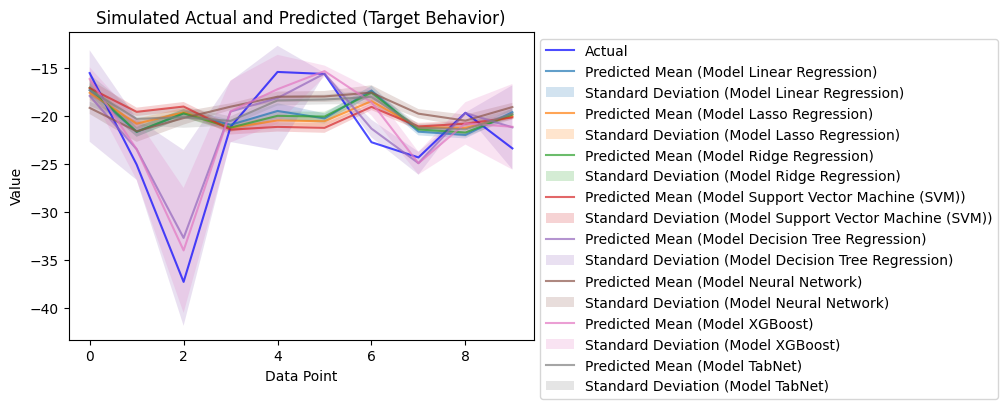

In [ ]:
# Evaluation plots
names = ["Behavior"]
model_names = ["Linear Regression", "Lasso Regression", "Ridge Regression", "Support Vector Machine (SVM)",
                   "Decision Tree Regression", "Neural Network", "XGBoost", "TabNet"]

num_models = len(model_dictionary)
num_targets = 1
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    models = model_dictionary[i]
    y_pred_models[i] = [bc.inverse_transform(model.predict(X_test).reshape(-1, 1)) for model in models]
inverse_y = bc.inverse_transform(y_test)
for i in range(num_targets):
    y_test_targets[i] = inverse_y

for t in range(num_targets):
  y_test_target = y_test_targets[t]
  plt.figure(figsize=(6, 4))
  plt.plot(range(len(y_test_target)), y_test_target, label='Actual', color='blue', alpha=0.7)
  for model_type in range(len(y_pred_models[0])):
    mean = np.zeros_like(y_pred_models[0][model_type][:, t])
    squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      mean += y_pred_fold
    mean = mean / len(y_pred_models)
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      squared_diff_sum += (y_pred_fold - mean) ** 2
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    plt.plot(range(len(y_test_target)), mean, label=f'Predicted Mean (Model {model_names[model_type]})', alpha=0.7)
    plt.fill_between(range(len(y_test_target)), mean - std_deviation, mean + std_deviation, alpha=0.2, label=f'Standard Deviation (Model {model_names[model_type]})')
  plt.title(f'Simulated Actual and Predicted (Target {names[t]})')
  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()